In [224]:
#@title Imports for Project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [225]:
df = pd.read_csv('../data/cleaned_data.csv')
df.head()

,id,timestamp,day_of_week,month,day,year,time,datetime,hour,timezone,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,1.543616e+09,Friday,November,30,2018,22:13,2018-11-30 22:13:01,22,America/New_York,...,0.0003,1543593600,28.79,1543579200,42.52,1543600800,26.41,1543575600,40.53,1543611600
1,23f145da-f0c1-4d1f-a184-496bc003a7db,1.544698e+09,Thursday,December,13,2018,10:50,2018-12-13 10:50:11,10,America/New_York,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
2,357559cb-8c58-4278-a41a-e33b2e0997a3,1.544729e+09,Thursday,December,13,2018,19:15,2018-12-13 19:15:03,19,America/New_York,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
3,50ef1165-9d23-416c-a65c-18906207b295,1.545005e+09,Sunday,December,16,2018,23:55,2018-12-16 23:55:11,23,America/New_York,...,0.1252,1544979600,39.22,1544954400,43.83,1544990400,33.98,1545019200,38.38,1544986800
4,91c4861c-1780-42b0-bca1-bbd64a422cc3,1.544748e+09,Friday,December,14,2018,00:40,2018-12-14 00:40:07,0,America/New_York,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800


Since year and surge_multiplier have constant values they can be dropped. 

In [226]:
df = df.drop(['year', 'surge_multiplier'],axis=1)
df.head()

,id,timestamp,day_of_week,month,day,time,datetime,hour,timezone,source,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,1.543616e+09,Friday,November,30,22:13,2018-11-30 22:13:01,22,America/New_York,North End,...,0.0003,1543593600,28.79,1543579200,42.52,1543600800,26.41,1543575600,40.53,1543611600
1,23f145da-f0c1-4d1f-a184-496bc003a7db,1.544698e+09,Thursday,December,13,10:50,2018-12-13 10:50:11,10,America/New_York,North End,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
2,357559cb-8c58-4278-a41a-e33b2e0997a3,1.544729e+09,Thursday,December,13,19:15,2018-12-13 19:15:03,19,America/New_York,North End,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
3,50ef1165-9d23-416c-a65c-18906207b295,1.545005e+09,Sunday,December,16,23:55,2018-12-16 23:55:11,23,America/New_York,North End,...,0.1252,1544979600,39.22,1544954400,43.83,1544990400,33.98,1545019200,38.38,1544986800
4,91c4861c-1780-42b0-bca1-bbd64a422cc3,1.544748e+09,Friday,December,14,00:40,2018-12-14 00:40:07,0,America/New_York,North End,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800


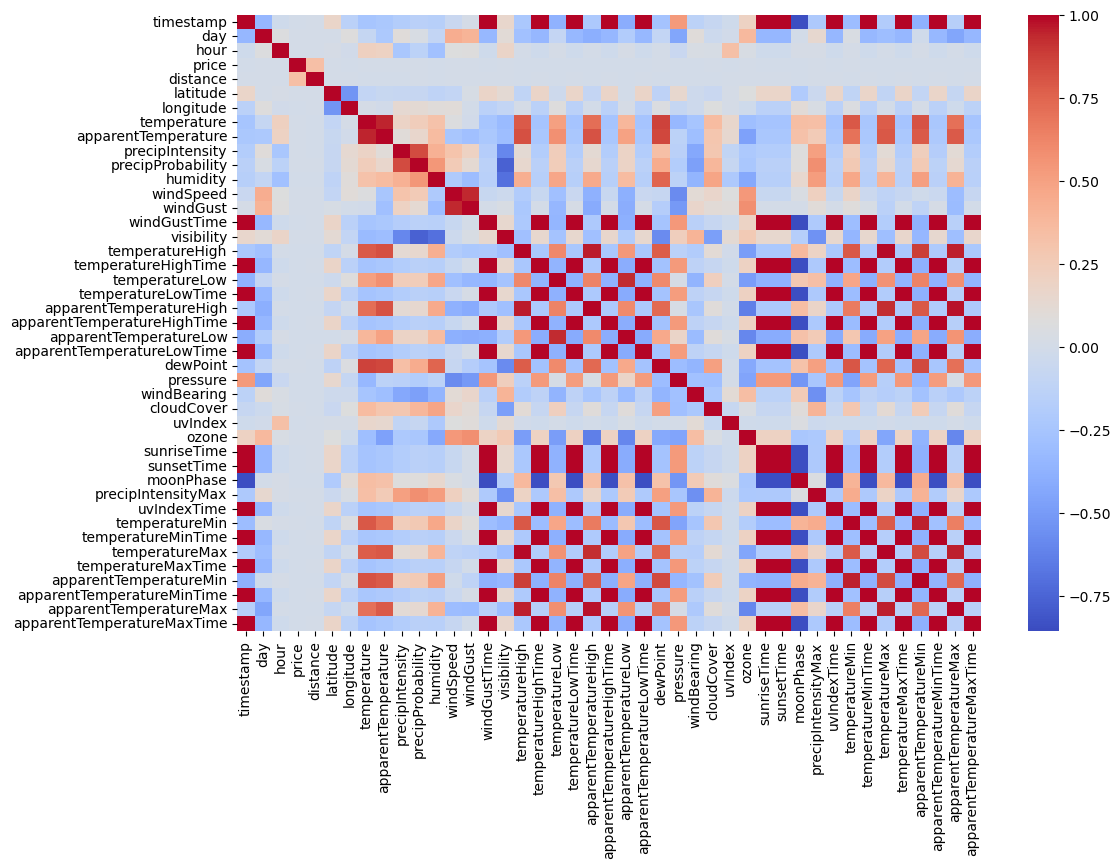

In [227]:
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, fmt=".2f", cmap='coolwarm')
plt.show()

We can use this correlation matrix to determine which features have correlation to the price.

In [228]:
price_correlations = corr_matrix['price'].drop('price').abs().sort_values()
print(price_correlations)

apparentTemperatureMin         0.000066
apparentTemperatureMinTime     0.000112
temperatureMax                 0.000117
temperatureMinTime             0.000142
windGustTime                   0.000230
apparentTemperatureLowTime     0.000232
timestamp                      0.000232
temperatureLowTime             0.000234
uvIndexTime                    0.000277
sunsetTime                     0.000284
sunriseTime                    0.000284
temperatureHighTime            0.000310
apparentTemperatureHighTime    0.000336
temperatureMaxTime             0.000355
apparentTemperatureMaxTime     0.000368
visibility                     0.000447
apparentTemperatureMax         0.000482
temperatureHigh                0.000516
uvIndex                        0.000531
longitude                      0.000574
apparentTemperature            0.000642
apparentTemperatureLow         0.000682
dewPoint                       0.000741
moonPhase                      0.000807
humidity                       0.000860


Distance seems to have the most significant impact on price. To understand the impact of other features, we can take a closer look on climate and temperature related columns. 

In [229]:
cli_temp_col = ['price','temperature', 'apparentTemperature', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust',
       'windGustTime', 'visibility', 'temperatureHigh', 'temperatureHighTime',
       'temperatureLow', 'temperatureLowTime', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'dewPoint', 'pressure', 'windBearing',
       'cloudCover', 'uvIndex', 'ozone', 'sunriseTime', 'sunsetTime',
       'moonPhase', 'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime']
df_new = df[cli_temp_col]
df_new.head()

,price,temperature,apparentTemperature,precipIntensity,precipProbability,humidity,windSpeed,windGust,windGustTime,visibility,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,12.0,40.13,38.08,0.0000,0.00,0.60,3.38,3.99,1543554000,9.833,...,0.0003,1543593600,28.79,1543579200,42.52,1543600800,26.41,1543575600,40.53,1543611600
1,16.0,20.38,20.38,0.0000,0.00,0.66,2.94,3.22,1544738400,9.831,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
2,7.5,32.85,32.85,0.0000,0.00,0.56,2.65,3.83,1544738400,9.959,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
3,7.5,41.29,36.01,0.0567,0.94,0.86,8.30,8.30,1545015600,4.054,...,0.1252,1544979600,39.22,1544954400,43.83,1544990400,33.98,1545019200,38.38,1544986800
4,26.0,31.25,31.25,0.0000,0.00,0.64,2.62,3.54,1544738400,10.000,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800


<Axes: >

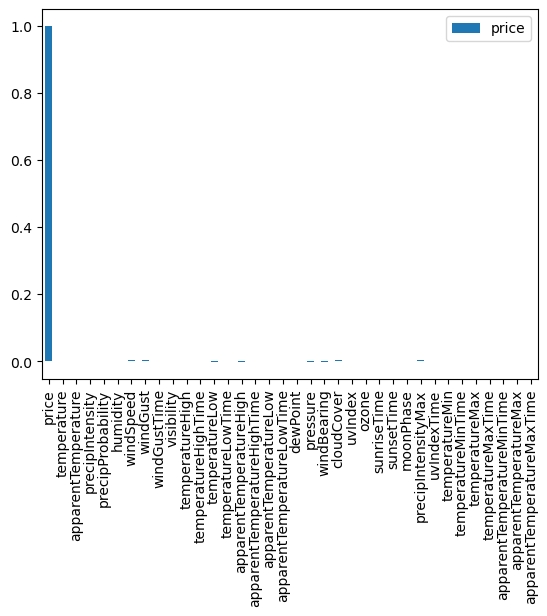

In [230]:
correlation=df_new.corr()[['price']]
price_corr=correlation[(correlation['price']>0.0001)|(correlation['price']<-0.0001)]
price_corr.plot.bar() 

All climate and temperature related columns have weak correlation to price, so they will be removed. 

In [231]:
df = df.drop(cli_temp_col[1:],axis=1)
df.head()

,id,timestamp,day_of_week,month,day,time,datetime,hour,timezone,source,...,cab_type,product_id,name,price,distance,latitude,longitude,short_summary,long_summary,icon
0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,1.543616e+09,Friday,November,30,22:13,2018-11-30 22:13:01,22,America/New_York,North End,...,Uber,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,12.0,1.11,42.3647,-71.0542,Overcast,Mostly cloudy throughout the day.,cloudy
1,23f145da-f0c1-4d1f-a184-496bc003a7db,1.544698e+09,Thursday,December,13,10:50,2018-12-13 10:50:11,10,America/New_York,North End,...,Uber,6c84fd89-3f11-4782-9b50-97c468b19529,Black,16.0,1.11,42.3647,-71.0542,Clear,Partly cloudy throughout the day.,clear-night
2,357559cb-8c58-4278-a41a-e33b2e0997a3,1.544729e+09,Thursday,December,13,19:15,2018-12-13 19:15:03,19,America/New_York,North End,...,Uber,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,7.5,1.11,42.3647,-71.0542,Mostly Cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,50ef1165-9d23-416c-a65c-18906207b295,1.545005e+09,Sunday,December,16,23:55,2018-12-16 23:55:11,23,America/New_York,North End,...,Uber,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,7.5,1.11,42.3647,-71.0542,Light Rain,Rain throughout the day.,rain
4,91c4861c-1780-42b0-bca1-bbd64a422cc3,1.544748e+09,Friday,December,14,00:40,2018-12-14 00:40:07,0,America/New_York,North End,...,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,26.0,1.11,42.3647,-71.0542,Overcast,Partly cloudy throughout the day.,cloudy


We can also examine the categorical columns.

In [232]:
cat_col = df.select_dtypes(include=['object','category']).columns.tolist()
df_cat = df[cat_col]
df_cat.head()

,id,day_of_week,month,time,datetime,timezone,source,destination,cab_type,product_id,name,short_summary,long_summary,icon
0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,Friday,November,22:13,2018-11-30 22:13:01,America/New_York,North End,West End,Uber,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,Overcast,Mostly cloudy throughout the day.,cloudy
1,23f145da-f0c1-4d1f-a184-496bc003a7db,Thursday,December,10:50,2018-12-13 10:50:11,America/New_York,North End,West End,Uber,6c84fd89-3f11-4782-9b50-97c468b19529,Black,Clear,Partly cloudy throughout the day.,clear-night
2,357559cb-8c58-4278-a41a-e33b2e0997a3,Thursday,December,19:15,2018-12-13 19:15:03,America/New_York,North End,West End,Uber,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,Mostly Cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,50ef1165-9d23-416c-a65c-18906207b295,Sunday,December,23:55,2018-12-16 23:55:11,America/New_York,North End,West End,Uber,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,Light Rain,Rain throughout the day.,rain
4,91c4861c-1780-42b0-bca1-bbd64a422cc3,Friday,December,00:40,2018-12-14 00:40:07,America/New_York,North End,West End,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,Overcast,Partly cloudy throughout the day.,cloudy


In [233]:
for col in df_cat:
    print(f'{col} : {df_cat[col].unique()}')
    print()

id : ['009e9c53-074d-43cf-aef2-0fbc7a47ed3d'
 '23f145da-f0c1-4d1f-a184-496bc003a7db'
 '357559cb-8c58-4278-a41a-e33b2e0997a3' ...
 '633a3fc3-1f86-4b9e-9d48-2b7132112341'
 '727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e'
 'e7fdc087-fe86-40a5-a3c3-3b2a8badcbda']

day_of_week : ['Friday' 'Thursday' 'Sunday' 'Monday' 'Tuesday' 'Saturday' 'Wednesday']

month : ['November' 'December']

time : ['22:13' '10:50' '19:15' ... '07:06' '05:54' '08:24']

datetime : ['2018-11-30 22:13:01' '2018-12-13 10:50:11' '2018-12-13 19:15:03' ...
 '2018-12-18 08:40:06' '2018-12-17 07:15:07' '2018-11-30 05:23:02']

timezone : ['America/New_York']

source : ['North End' 'Beacon Hill' 'North Station' 'Boston University'
 'South Station' 'Fenway' 'Theatre District' 'West End' 'Back Bay'
 'Northeastern University' 'Haymarket Square' 'Financial District']

destination : ['West End' 'South Station' 'Fenway' 'Beacon Hill' 'North Station'
 'Back Bay' 'North End' 'Northeastern University' 'Financial District'
 'Theatre District' 'B

Dropping timezone as there is only one timezone, and id, datetime, product_id and time as they are not categorical features. Also, dropping long summary, latitude and longitude for similar reasons. 

In [234]:
df = df.drop(['timestamp','timezone', 'id', 'datetime', 'product_id', 'time', 'long_summary', 'latitude', 'longitude'],axis=1)
df.head()

,day_of_week,month,day,hour,source,destination,cab_type,name,price,distance,short_summary,icon
0,Friday,November,30,22,North End,West End,Uber,UberXL,12.0,1.11,Overcast,cloudy
1,Thursday,December,13,10,North End,West End,Uber,Black,16.0,1.11,Clear,clear-night
2,Thursday,December,13,19,North End,West End,Uber,UberX,7.5,1.11,Mostly Cloudy,partly-cloudy-day
3,Sunday,December,16,23,North End,West End,Uber,WAV,7.5,1.11,Light Rain,rain
4,Friday,December,14,0,North End,West End,Uber,Black SUV,26.0,1.11,Overcast,cloudy


We can use Onehot Encoder to encode these category columns.

In [235]:
df = df.reset_index(drop=True)

In [236]:
cat_col = df.select_dtypes(include=['object','category']).columns.tolist()
print(cat_col)

for col in cat_col:
    encoder = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(encoder.fit_transform(df[[col]]).toarray())
    enc_df.columns = encoder.get_feature_names_out([col])
    df = df.drop(col, axis=1)
    df = pd.concat([df, enc_df], axis=1)

['day_of_week', 'month', 'source', 'destination', 'cab_type', 'name', 'short_summary', 'icon']


In [237]:
df.head()

,day,hour,price,distance,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,...,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain,icon_ clear-day,icon_ clear-night,icon_ cloudy,icon_ fog,icon_ partly-cloudy-day,icon_ partly-cloudy-night,icon_ rain
0,30,22,12.0,1.11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,13,10,16.0,1.11,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,13,19,7.5,1.11,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,23,7.5,1.11,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14,0,26.0,1.11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


To narrow down the features that affect price, we will be analyzing per column. Starting with analysis of source columns with price:

In [238]:
source_col = ['price','source_Back Bay', 'source_Beacon Hill', 'source_Boston University',
       'source_Fenway', 'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End']
df_new = df[source_col]
df_new.head()

,price,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End
0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,26.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

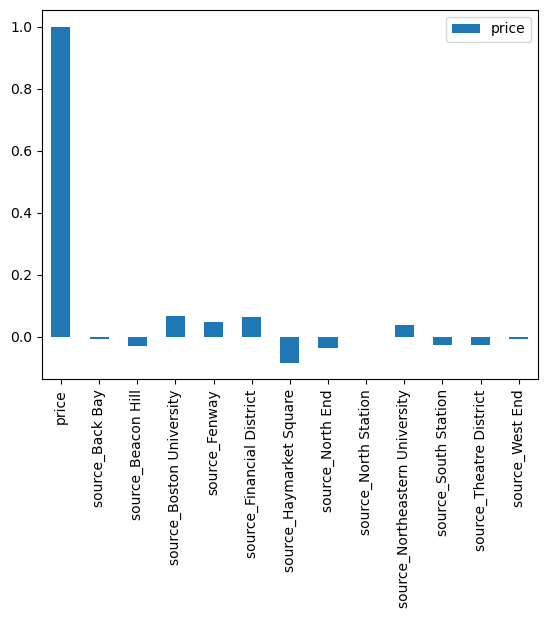

In [239]:
correlation=df_new.corr()[['price']]
price_corr=correlation[(correlation['price']>0.0001)|(correlation['price']<-0.0001)]
price_corr.plot.bar() 

Source does not have that much of a affect on price, so it will be removed.

In [240]:
df = df.drop(source_col[1:],axis=1)
df.head()

,day,hour,price,distance,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,...,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain,icon_ clear-day,icon_ clear-night,icon_ cloudy,icon_ fog,icon_ partly-cloudy-day,icon_ partly-cloudy-night,icon_ rain
0,30,22,12.0,1.11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,13,10,16.0,1.11,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,13,19,7.5,1.11,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,23,7.5,1.11,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14,0,26.0,1.11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Analysis of destination columns with price: 

In [241]:
destination_col = ['price','destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End']
df_new = df[destination_col]
df_new.head()

,price,destination_Back Bay,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End
0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<Axes: >

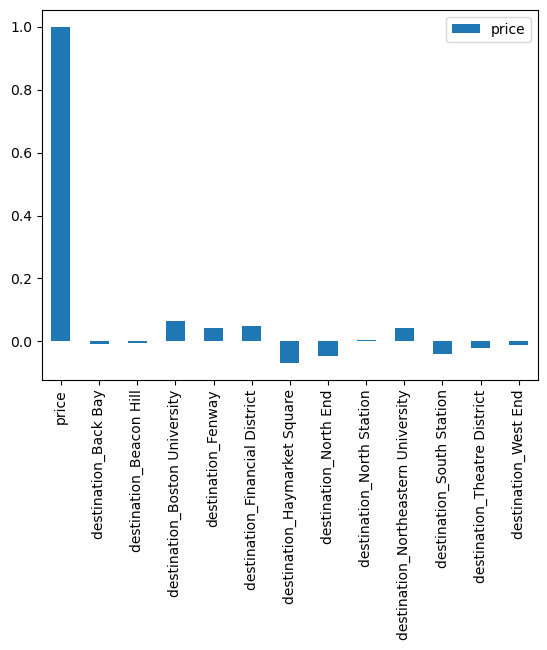

In [242]:
correlation=df_new.corr()[['price']]
price_corr=correlation[(correlation['price']>0.0001)|(correlation['price']<-0.0001)]
price_corr.plot.bar() 

Destination does not have that much of affect on price, so it will be removed.

In [243]:
df = df.drop(destination_col[1:],axis=1)
df.head()

,day,hour,price,distance,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,...,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain,icon_ clear-day,icon_ clear-night,icon_ cloudy,icon_ fog,icon_ partly-cloudy-day,icon_ partly-cloudy-night,icon_ rain
0,30,22,12.0,1.11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,13,10,16.0,1.11,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,13,19,7.5,1.11,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,23,7.5,1.11,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14,0,26.0,1.11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Analysis of short summary columns with price: 

In [244]:
summary_cols = ['price','short_summary_ Drizzle ', 'short_summary_ Foggy ',
       'short_summary_ Light Rain ', 'short_summary_ Mostly Cloudy ',
       'short_summary_ Overcast ', 'short_summary_ Partly Cloudy ',
       'short_summary_ Possible Drizzle ', 'short_summary_ Rain ','short_summary_ Clear ']
df_new = df[summary_cols]
df_new.head()

,price,short_summary_ Drizzle,short_summary_ Foggy,short_summary_ Light Rain,short_summary_ Mostly Cloudy,short_summary_ Overcast,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain,short_summary_ Clear
0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<Axes: >

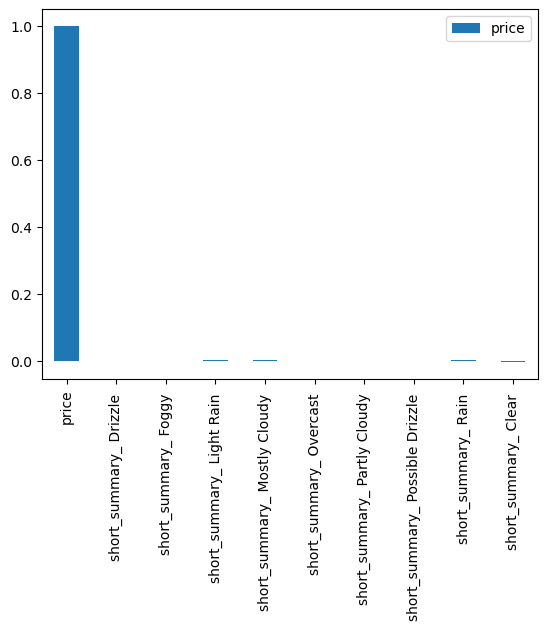

In [245]:
correlation=df_new.corr()[['price']]
price_corr=correlation[(correlation['price']>0.0001)|(correlation['price']<-0.0001)] #OR
price_corr.plot.bar() 

There is a really low impact of summary with price, so it will be removed.

In [246]:
df = df.drop(summary_cols[1:],axis=1)
df.head()

,day,hour,price,distance,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,...,name_UberX,name_UberXL,name_WAV,icon_ clear-day,icon_ clear-night,icon_ cloudy,icon_ fog,icon_ partly-cloudy-day,icon_ partly-cloudy-night,icon_ rain
0,30,22,12.0,1.11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,13,10,16.0,1.11,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,13,19,7.5,1.11,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,23,7.5,1.11,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14,0,26.0,1.11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Analysis of day of the week columns with price: 

In [247]:
day_of_week_cols = ['price','day_of_week_Monday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'day_of_week_Thursday',
       'day_of_week_Friday', 'day_of_week_Saturday',
       'day_of_week_Sunday']
df_new = df[day_of_week_cols]
df_new.head()

,price,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday,day_of_week_Sunday
0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,7.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,7.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,26.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<Axes: >

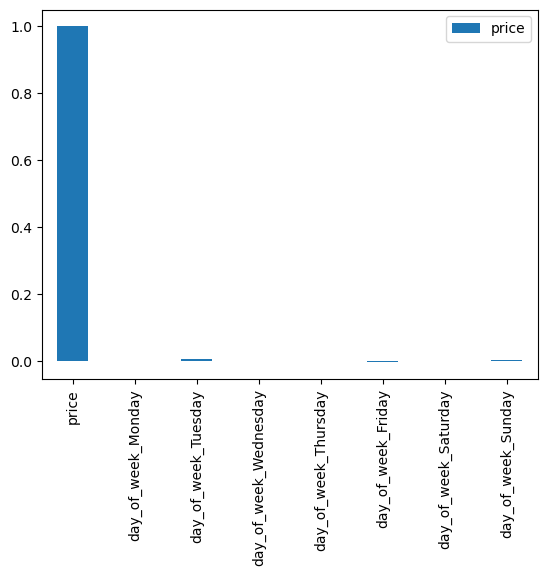

In [248]:
correlation=df_new.corr()[['price']]
price_corr=correlation[(correlation['price']>0.0001)|(correlation['price']<-0.0001)]
price_corr.plot.bar() 

The day of the week and price affect is low, so it can be removed.

In [249]:
df = df.drop(day_of_week_cols[1:],axis=1)
df.head()

,day,hour,price,distance,month_December,month_November,cab_type_Uber,name_Black,name_Black SUV,name_UberPool,name_UberX,name_UberXL,name_WAV,icon_ clear-day,icon_ clear-night,icon_ cloudy,icon_ fog,icon_ partly-cloudy-day,icon_ partly-cloudy-night,icon_ rain
0,30,22,12.0,1.11,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,13,10,16.0,1.11,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,13,19,7.5,1.11,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,23,7.5,1.11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14,0,26.0,1.11,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Analysis of ICON columns with price: 

In [250]:
icon_cols = ['price','icon_ clear-day ', 'icon_ clear-night ', 'icon_ cloudy ', 'icon_ fog ',
       'icon_ partly-cloudy-day ', 'icon_ partly-cloudy-night ',
       'icon_ rain ']
df_new = df[icon_cols]
df_new.head()

,price,icon_ clear-day,icon_ clear-night,icon_ cloudy,icon_ fog,icon_ partly-cloudy-day,icon_ partly-cloudy-night,icon_ rain
0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,7.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,26.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<Axes: >

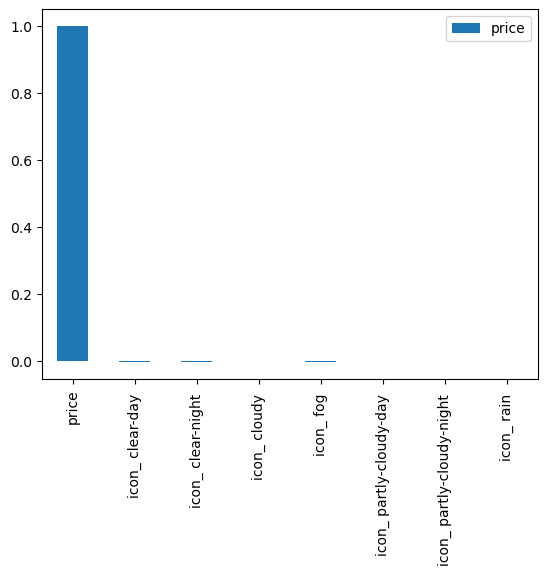

In [251]:
correlation=df_new.corr()[['price']]
price_corr=correlation[(correlation['price']>0.0001)|(correlation['price']<-0.0001)]
price_corr.plot.bar()

ICON columns have little affect on price, so they will be removed.

In [252]:
df = df.drop(icon_cols[1:],axis=1)
df.head()

,day,hour,price,distance,month_December,month_November,cab_type_Uber,name_Black,name_Black SUV,name_UberPool,name_UberX,name_UberXL,name_WAV
0,30,22,12.0,1.11,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,13,10,16.0,1.11,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,13,19,7.5,1.11,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,23,7.5,1.11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14,0,26.0,1.11,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Analysis of name columns with price: 

In [253]:
name_cols = ['price','name_Black', 'name_Black SUV','name_UberPool','name_UberX', 'name_UberXL', 'name_WAV']
df_new = df[name_cols]
df_new.head()

,price,name_Black,name_Black SUV,name_UberPool,name_UberX,name_UberXL,name_WAV
0,12.0,0.0,0.0,0.0,0.0,1.0,0.0
1,16.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7.5,0.0,0.0,0.0,1.0,0.0,0.0
3,7.5,0.0,0.0,0.0,0.0,0.0,1.0
4,26.0,0.0,1.0,0.0,0.0,0.0,0.0


<Axes: >

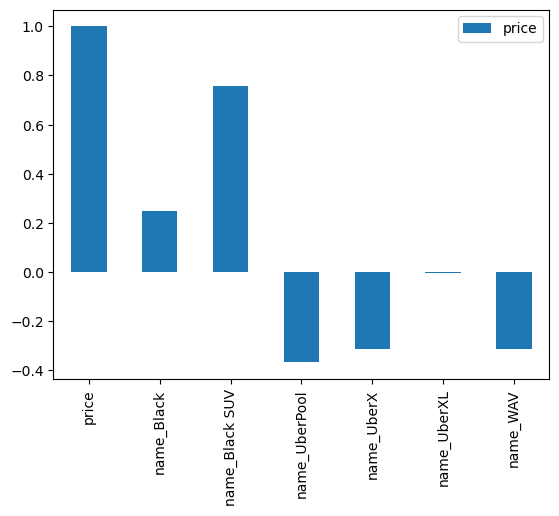

In [254]:
correlation=df_new.corr()[['price']]
price_corr=correlation[(correlation['price']>0.0001)|(correlation['price']<-0.0001)] #OR
price_corr.plot.bar()

Some types of uber have a clear postive or negative affect on price.

Lets take a look at the rest of the metrics and it's potentially affect on price.

In [255]:
rest_of_cols =['price','hour', 'day', 'month_November', 'month_December','distance']
df_new = df[rest_of_cols]
df_new.head()

,price,hour,day,month_November,month_December,distance
0,12.0,22,30,1.0,0.0,1.11
1,16.0,10,13,0.0,1.0,1.11
2,7.5,19,13,0.0,1.0,1.11
3,7.5,23,16,0.0,1.0,1.11
4,26.0,0,14,0.0,1.0,1.11


<Axes: >

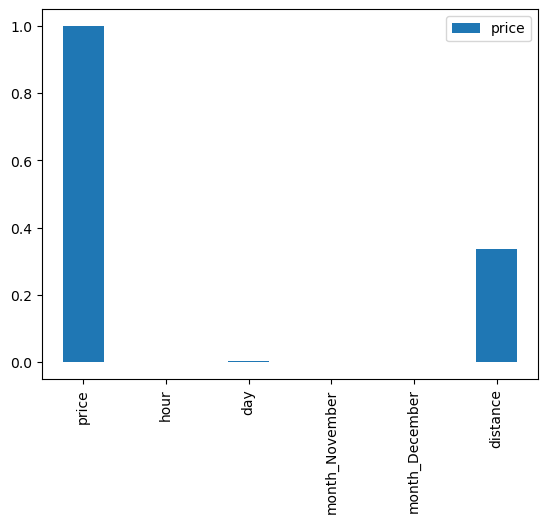

In [256]:
correlation=df_new.corr()[['price']]
price_corr=correlation[(correlation['price']>0.0001)|(correlation['price']<-0.0001)]
price_corr.plot.bar() 

Since only distance has a strong correlation with price, the rest will be dropped.

In [257]:
df = df.drop(['hour', 'day', 'month_November', 'month_December'],axis=1)
df.head()

,price,distance,cab_type_Uber,name_Black,name_Black SUV,name_UberPool,name_UberX,name_UberXL,name_WAV
0,12.0,1.11,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,16.0,1.11,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7.5,1.11,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,7.5,1.11,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,26.0,1.11,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Now that we have determined the features that have a strong affect on price, we need to also check for outliers within price. Removing the outliers will decrease error values. 

In [258]:
max_price = df['price'].quantile(0.99)
min_price = df['price'].quantile(0.01)
print(max_price, min_price)

39.5 6.0


Given that 39.5 is the max cost, and 6.0 is the min cost, we need to assess the impact on the overall data. 

Number of rides that are above $40 is 3015
Precentage of rides that above $40 is 0.001013%


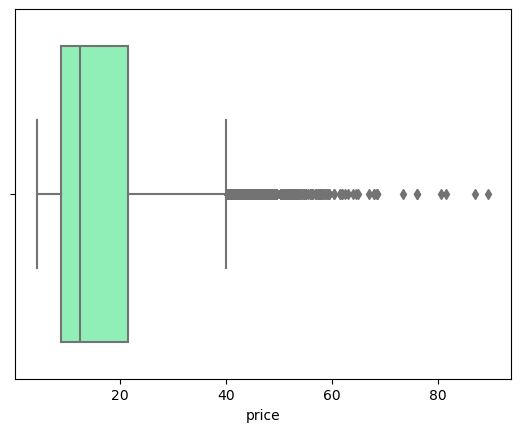

In [259]:
sns.boxplot(data=df,x='price',palette='rainbow',orient='h')

num_outliers = np.count_nonzero(np.where(df['price'] > 40))
print("Number of rides that are above $40 is", num_outliers)
print("Precentage of rides that above $40 is {}%".format(round(np.count_nonzero(np.where(df['price'] > 40))/df.size, 6)))

These are therefore removed from the data.

In [260]:
out = np.where(df['price'] > 39)
df.drop(out[0], inplace = True)

(326970, 9)

Distance and the type of ubers are the features that affect the price most significantly. 

<Axes: >

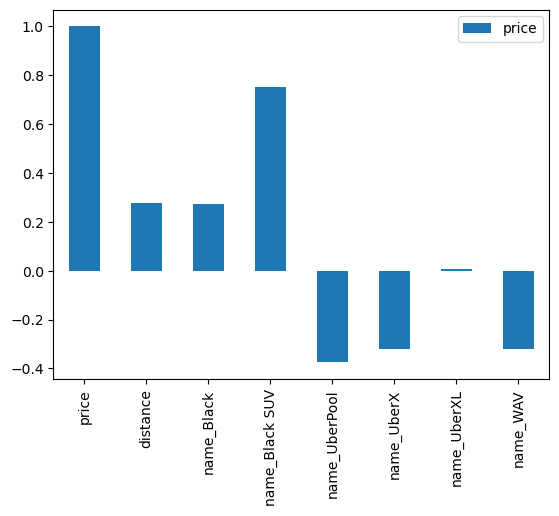

In [262]:
correlation=df.corr()[['price']]
price_corr=correlation[(correlation['price']>0.0001)|(correlation['price']<-0.0001)]
price_corr.plot.bar() 

In [263]:
df.to_csv('./data_feature_engineering.csv', index=False)